In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

from dopamine.agents.dqn import dqn_agent
from dopamine.agents.implicit_quantile import implicit_quantile_agent
from dopamine.agents.rainbow import rainbow_agent
from dopamine.agents.tbiqn import tbiqn_agent
from dopamine.discrete_domains import atari_lib
from dopamine.discrete_domains import checkpointer
from dopamine.discrete_domains import iteration_statistics
from dopamine.discrete_domains import logger

import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

import gin.tf

In [2]:
def create_atari_environment(game_name=None, sticky_actions=True):
  assert game_name is not None
  game_version = 'v0' if sticky_actions else 'v4'
  full_game_name = '{}NoFrameskip-{}'.format(game_name, game_version)
  env = gym.make(full_game_name)
  # Strip out the TimeLimit wrapper from Gym, which caps us at 100k frames. We
  # handle this time limit internally instead, which lets us cap at 108k frames
  # (30 minutes). The TimeLimit wrapper also plays poorly with saving and
  # restoring states.
  env = env.env
  env = AtariPreprocessing(env)
  return env
def initialize_checkpointer_and_maybe_resume(checkpoint_file_prefix):
    """Reloads the latest checkpoint if it exists.

    This method will first create a `Checkpointer` object and then call
    `checkpointer.get_latest_checkpoint_number` to determine if there is a valid
    checkpoint in self._checkpoint_dir, and what the largest file number is.
    If a valid checkpoint file is found, it will load the bundled data from this
    file and will pass it to the agent for it to reload its data.
    If the agent is able to successfully unbundle, this method will verify that
    the unbundled data contains the keys,'logs' and 'current_iteration'. It will
    then load the `Logger`'s data from the bundle, and will return the iteration
    number keyed by 'current_iteration' as one of the return values (along with
    the `Checkpointer` object).

    Args:
      checkpoint_file_prefix: str, the checkpoint file prefix.

    Returns:
      start_iteration: int, the iteration number to start the experiment from.
      experiment_checkpointer: `Checkpointer` object for the experiment.
    """
    checkpointer = checkpointer.Checkpointer(self._checkpoint_dir,
                                                   checkpoint_file_prefix)
    self._start_iteration = 0
    # Check if checkpoint exists. Note that the existence of checkpoint 0 means
    # that we have finished iteration 0 (so we will start from iteration 1).
    latest_checkpoint_version = checkpointer.get_latest_checkpoint_number(
        self._checkpoint_dir)
    if latest_checkpoint_version >= 0:
      experiment_data = self._checkpointer.load_checkpoint(
          latest_checkpoint_version)
      if self._agent.unbundle(
          self._checkpoint_dir, latest_checkpoint_version, experiment_data):
        if experiment_data is not None:
          assert 'logs' in experiment_data
          assert 'current_iteration' in experiment_data
          self._logger.data = experiment_data['logs']
          self._start_iteration = experiment_data['current_iteration'] + 1
        tf.logging.info('Reloaded checkpoint and will start from iteration %d',
                        self._start_iteration)


In [4]:
gamename = 'StarGunner'

base_dir = 'tmp/test'
checkpoint_dir = 'expriment/k64/stargunner/checkpoints'
summary_writer = tf.summary.FileWriter(base_dir)
environment = atari_lib.create_atari_environment(gamename)
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session('', config=config)


In [5]:
agent = tbiqn_agent.TbImplicitQuantileAgent(
    sess=sess,
    network=atari_lib.TbImplicitQuantileNetwork,
    num_actions=environment.action_space.n,
    kappa=1.0,
    num_tau_samples=64,
    num_tau_prime_samples=64,
    num_quantile_samples=64)
agent.eval_mode = True

INFO:tensorflow:Creating TbImplicitQuantileAgent agent with the following parameters:
INFO:tensorflow:	 gamma: 0.990000
INFO:tensorflow:	 update_horizon: 1.000000
INFO:tensorflow:	 min_replay_history: 20000
INFO:tensorflow:	 update_period: 4
INFO:tensorflow:	 target_update_period: 8000
INFO:tensorflow:	 epsilon_train: 0.010000
INFO:tensorflow:	 epsilon_eval: 0.001000
INFO:tensorflow:	 epsilon_decay_period: 250000
INFO:tensorflow:	 tf_device: /cpu:*
INFO:tensorflow:	 use_staging: True
INFO:tensorflow:	 optimizer: <tensorflow.python.training.adam.AdamOptimizer object at 0x7f516587a860>
INFO:tensorflow:	 max_tf_checkpoints_to_keep: 4
INFO:tensorflow:Creating a OutOfGraphPrioritizedReplayBuffer replay memory with the following parameters:
INFO:tensorflow:	 observation_shape: (84, 84)
INFO:tensorflow:	 observation_dtype: <class 'numpy.uint8'>
INFO:tensorflow:	 terminal_dtype: <class 'numpy.uint8'>
INFO:tensorflow:	 stack_size: 4
INFO:tensorflow:	 replay_capacity: 1000000
INFO:tensorflow:	 b

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
  def call(self, state, num_quantiles):
    """Creates the output tensor/op given the state tensor as input.

    See https://www.tensorflow.org/api_docs/python/tf/keras/Model for more
    information on this. Note that tf.keras.Model implements `call` which is
    wrapped by `__call__` function by tf.keras.Model.

    Args:
      state: `tf.Tensor`, contains the agent's current state.
      num_quantiles: int, number of quantile inputs.
    Returns:
      collections.namedtuple, that contains (quantile_values, quantiles).
    """
    batch_size = state.get_shape().as_list()[0]
    x = tf.cast(state, tf.float32)
    x = tf.div(x, 255.)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    weight = self.weight1(x)
    weight = tf.reshape(self.weight2(weight),[batch_size, 2,self.num_actions])
    
    state_vector_length = x.get_shape().as_list()[-1]#(batch,7*7*64)
   

  def call(self, state, num_quantiles):
    """Creates the output tensor/op given the state tensor as input.

    See https://www.tensorflow.org/api_docs/python/tf/keras/Model for more
    information on this. Note that tf.keras.Model implements `call` which is
    wrapped by `__call__` function by tf.keras.Model.

    Args:
      state: `tf.Tensor`, contains the agent's current state.
      num_quantiles: int, number of quantile inputs.
    Returns:
      collections.namedtuple, that contains (quantile_values, quantiles).
    """
    batch_size = state.get_shape().as_list()[0]
    x = tf.cast(state, tf.float32)
    x = tf.div(x, 255.)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    weight = self.weight1(x)
    weight = tf.reshape(self.weight2(weight),[batch_size, 2,self.num_actions])
    
    state_vector_length = x.get_shape().as_list()[-1]#(batch,7*7*64)
    state_net_tiled = tf.tile(tf.expand_dims(x,axis=1), [1,num_quantiles, 1])#(batch

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please use tf.global_variables instead.
INFO:tensorflow:legacy_checkpoint_load: False


In [6]:
from dopamine.discrete_domains import checkpointer
checkpointers = checkpointer.Checkpointer(checkpoint_dir,'ckpt')
start_iteration = 0
# Check if checkpoint exists. Note that the existence of checkpoint 0 means
# that we have finished iteration 0 (so we will start from iteration 1).
latest_checkpoint_version = checkpointer.get_latest_checkpoint_number(checkpoint_dir)
latest_checkpoint_version

20

In [7]:
if latest_checkpoint_version >= 0:
    experiment_data = checkpointers.load_checkpoint(
      latest_checkpoint_version)
    if agent._saver.restore(agent._sess,
                        os.path.join(checkpoint_dir,
                                     'tf_ckpt-{}'.format(latest_checkpoint_version))):

        if experiment_data is not None:
            assert 'logs' in experiment_data
            assert 'current_iteration' in experiment_data
#             logger.data = experiment_data['logs']
            start_iteration = experiment_data['current_iteration'] + 1
        tf.logging.info('Reloaded checkpoint and will start from iteration %d',
                    start_iteration)


INFO:tensorflow:Restoring parameters from expriment/k64/stargunner/checkpoints/tf_ckpt-20


In [ ]:
def initialize_episode(environment,agent):

    initial_observation = environment.reset()
    return agent.begin_episode(initial_observation)

def run_one_step(environment,action):
    """Executes a single step in the environment.

    Args:
      action: int, the action to perform in the environment.

    Returns:
      The observation, reward, and is_terminal values returned from the
        environment.
    """
    observation, reward, is_terminal, _ = environment.step(action)
    return observation, reward, is_terminal


In [ ]:
action = initialize_episode(environment,agent)
observation, reward, is_terminal = run_one_step(environment,action)

agent._last_observation = agent._observation
agent._record_observation(observation)
a = sess.run(agent._net_outputs,{agent.state_ph: agent.state})

output_ph = agent.online_convnet(agent.state_ph,64)
b = sess.run(output_ph,{agent.state_ph:agent.state})
# print(a[0][0][:,0])
q = np.concatenate([a[0],b[0]],axis=1)[0]
taus = a[1][0][:,0]
taus1 = b[1][0][:,0]
tau = np.concatenate([taus,taus1],axis=0)
show = q[:,0][np.argsort(tau.squeeze())]
# print(tau.squeeze().shape)
# # np.argsort(show[])
# # print(np.argsort(tau).shape)
plt.plot(np.sort(taus),a[0][0,:,0],label='64')
plt.plot(np.sort(taus1),b[0][0,:,0],label='32')
plt.plot(np.sort(tau.squeeze()),show,label='all')
# import matplotlib.pyplot as plt 
# plt.imshow(agent.state[0])

(64,)


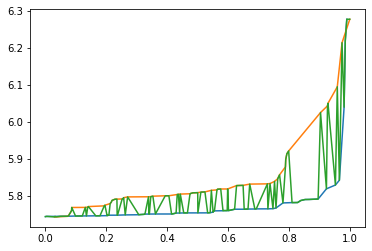

In [45]:
plt.plot(np.sort(taus),a[0][0,:,0],label='64')
plt.plot(np.sort(taus1),b[0][0,:,0],label='32')
plt.plot(np.sort(tau.squeeze()),show,label='all')
# plt.legend()
print(taus1.shape)
# import matplotlib.pyplot as plt 
# plt.imshow(agent.state[0])

In [9]:
quantiles = tf.range(0, 1,1/(64 + 1))
quantiles = tf.expand_dims((quantiles[:64]+quantiles[1:64+1])/2,0)
sess = tf.Session()
print(sess.run(quantiles))
sess.run(quantiles).shape


[[0.00769231 0.02307692 0.03846154 0.05384615 0.06923077 0.08461539
  0.1        0.11538462 0.13076924 0.14615385 0.16153847 0.17692308
  0.1923077  0.20769231 0.22307692 0.23846154 0.25384617 0.26923078
  0.2846154  0.3        0.31538463 0.33076924 0.34615386 0.36153847
  0.37692308 0.3923077  0.4076923  0.42307693 0.43846154 0.45384616
  0.46923077 0.4846154  0.5        0.5153847  0.5307692  0.5461539
  0.56153846 0.57692313 0.5923077  0.60769236 0.6230769  0.6384616
  0.65384614 0.6692308  0.6846154  0.70000005 0.7153846  0.7307693
  0.74615383 0.7615385  0.77692306 0.79230773 0.8076923  0.82307696
  0.8384615  0.8538462  0.86923075 0.8846154  0.9        0.91538465
  0.9307692  0.9461539  0.96153843 0.9769231 ]]


(1, 64)

In [42]:
num_quantile_samples = 64
quantiles = tf.range(0, 1,1/(num_quantile_samples+1) )+1/(num_quantile_samples+1)
quantiles = tf.expand_dims((quantiles[:num_quantile_samples]+quantiles[1:num_quantile_samples+1])/2,0)
# quantiles = tf.expand_dims(quantiles,0)
quantiles = tf.tile(quantiles, [32, 1])
print(quantiles)
sess= tf.Session()
sess.run(quantiles)

Tensor("Tile_4:0", shape=(32, 64), dtype=float32)


array([[0.02307692, 0.03846154, 0.05384615, ..., 0.96153843, 0.9769231 ,
        0.99230766],
       [0.02307692, 0.03846154, 0.05384615, ..., 0.96153843, 0.9769231 ,
        0.99230766],
       [0.02307692, 0.03846154, 0.05384615, ..., 0.96153843, 0.9769231 ,
        0.99230766],
       ...,
       [0.02307692, 0.03846154, 0.05384615, ..., 0.96153843, 0.9769231 ,
        0.99230766],
       [0.02307692, 0.03846154, 0.05384615, ..., 0.96153843, 0.9769231 ,
        0.99230766],
       [0.02307692, 0.03846154, 0.05384615, ..., 0.96153843, 0.9769231 ,
        0.99230766]], dtype=float32)

In [5]:
250000/8

31250.0